In [10]:
import sys; from pathlib import Path
src_dir = next(parent / 'src' for parent in Path().absolute().parents if (parent / 'src').is_dir())
sys.path.extend([str(src_dir), str(src_dir / 'pipelines')])
from imports import * ; current_dir = Path().resolve()

folder_outputs = create_output_folder(folder_name='Figures_Exercise_Constitutive')


# Model

| Index | Reaction | Description | Reaction Rate |
|-------|----------|-------------|---------------|
| $r_1$ | $ \xrightarrow[]{k_{r}} R_{n}$ | active gene produces mRNA | $k_{r} $ |
| $r_2$ | $R_{n} \xrightarrow[]{k_{t}} R_{c}$ | mRNA transport to cytoplasm | $k_{t} \cdot [R_{n}]$ |
| $r_3$ | $R_{c} \xrightarrow[]{k_{p}} R_{c} + P$ | mRNA in cytoplasm produces Protein | $k_{p} \cdot [R_{c}]$ |
| $r_4$ | $R_{n} \xrightarrow[]{\gamma_{r}} \phi$ | nuclear mRNA decay | $\gamma_{r} \cdot [R_{n}]$ |
| $r_5$ | $R_{c} \xrightarrow[]{\gamma_{r}} \phi$ | cytoplasm mRNA decay | $\gamma_{r} \cdot [R_{c}]$ |
| $r_6$ | $P \xrightarrow[]{\gamma_p} \phi$ | protein decay | $\gamma_p \cdot [P]$ |



## Adjusting $(k_t)$ to Incorporate Diffusion and Transport Rates from Simulated Cell Model

To adjust the parameter $(k_t)$, accounting for both the diffusion rate $(k_{diff_r})$ and the transport rate $(transport\_rate)$ from from Simulated Cell Model, we follow a multi-step process. This process aims to encapsulate the combined effects of RNA diffusion to the nuclear envelope and its subsequent transport into the cytosol.

### Step 1: Effective Diffusion Time $(T_{diff})$

First, we estimate the effective time $(T_{diff})$ it takes for an RNA molecule to diffuse to the nuclear envelope. Assuming a known average distance $(D)$ to the nuclear envelope, and given the diffusion rate $(k_{diff_r})$, the diffusion time can be approximated as:

$$T_{diff} = \frac{D^2}{2 \cdot k_{diff_r}}$$

This formula simplifies the complexity of cellular environments and assumes a direct, unobstructed path to the nuclear envelope.

### Step 2: Effective Transport Time $(T_{transport})$

Next, we define the effective time $(T_{transport})$ for RNA to be transported across the nuclear envelope, utilizing the transport rate $(transport\_rate)$:

$$T_{transport} = \frac{1}{transport\_rate}$$

### Step 3: Combining Effective Times

The total effective time $(T_{total})$ for an RNA molecule to move from the nucleus to the cytosol combines both diffusion and transport times:

$$T_{total} = T_{diff} + T_{transport}$$

### Step 4: Calculating Effective Rate $(k_t)$

Finally, we calculate an effective rate $(k_t)$ for RNA transport from the nucleus to the cytosol in Model 1, reflecting both diffusion and transport:

$$k_t = \frac{1}{T_{total}} = \frac{1}{\frac{D^2}{2 \cdot k_{diff_r}} + \frac{1}{transport\_rate}}$$

This equation provides a way to adjust $(k_t)$ in Model 1 to more accurately reflect the complex process of RNA movement within the cell, considering both its diffusion to the nuclear envelope and the subsequent transport into the cytosol.



# Solving unperturbed moodel
___

In [11]:
# Model Parameters
k_r = 2
k_p = 0.5
gamma_r = 0.05 # assuming gamma_rn = gamma_rc
gamma_p = 0.25
transport_rate = 0.5

diffusion_rate = 10 # assuming diffusion_rate_r = diffusion_rate_p
total_simulation_time = 200
nucleus_diameter = 40
number_of_trajectories = 100

cytosol_diameter = 70 
model_type = '2D'


# Calculating effective transport rate
effective_k_t = calculate_effective_kt(D=nucleus_diameter, k_diff_r=diffusion_rate, transport_rate=transport_rate, model_type=model_type) 
print('Effective transport rate: ', effective_k_t)
kt = effective_k_t
drug_application_time = None
inhibited_parameters=None
# Parameters for plotting
max_y_val =65
# adding burnin time to allow the system to reach steady state
burn_in_time = 0


Effective transport rate:  0.08333333333333333


In [12]:
# Model Parameters and initial conditions as dictionaries

parameter_values = {
            'k_r': k_r,
            'k_t': kt,
            'k_p': k_p,
            'gamma_r': gamma_r,
            'gamma_p': gamma_p,
        }

initial_conditions = {
    'R_n': 0,
    'R_c': 0,
    'P' : 0
}


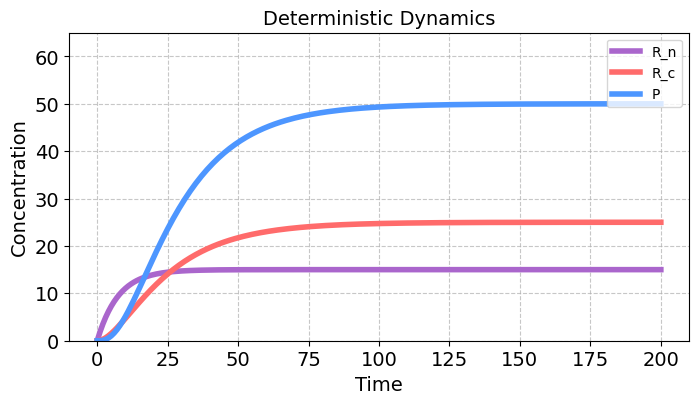

In [13]:
# Running the ODE model
time, concentrations_species =simulate_model(parameter_values, 
                                             initial_conditions, 
                                             total_simulation_time, 
                                             simulation_type='continuous', 
                                             burn_in_time=burn_in_time, 
                                             drug_application_time=drug_application_time, 
                                             inhibited_parameters=inhibited_parameters,
                                             )
plotting_deterministic(time,concentrations_species,species_colors,ylim_val=max_y_val,save_figure=True,folder_outputs=folder_outputs)

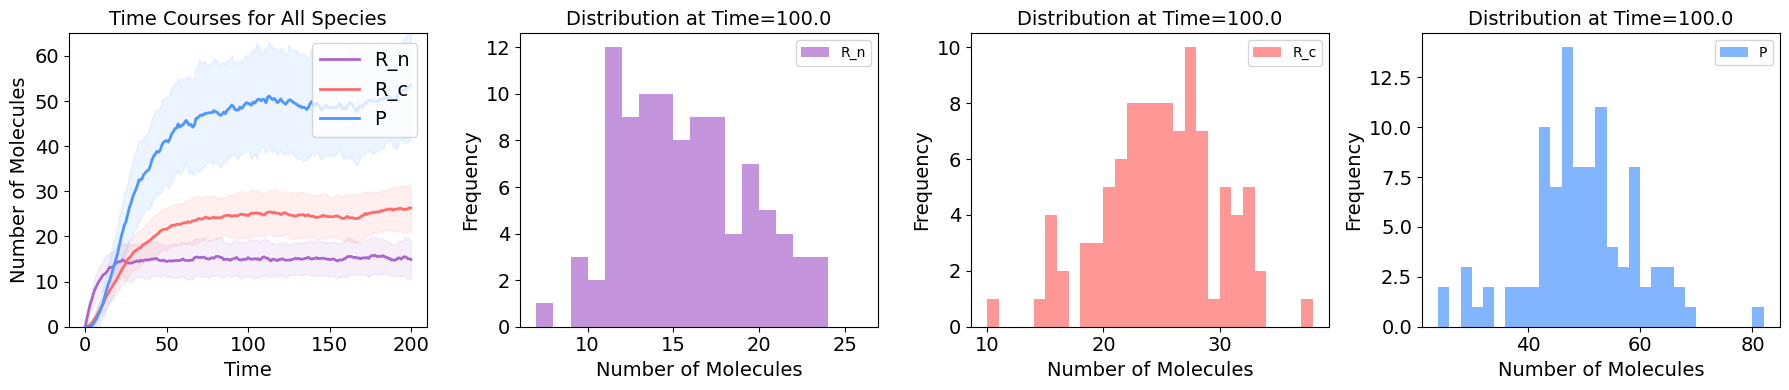

In [14]:
# Running SSA
time,trajectories_species  = simulate_model(parameter_values,
                                                  initial_conditions,
                                                  total_simulation_time,
                                                  simulation_type='discrete', 
                                                  burn_in_time=burn_in_time,
                                                  drug_application_time=drug_application_time,
                                                  inhibited_parameters=inhibited_parameters,
                                                  number_of_trajectories=number_of_trajectories)
plotting_combined(time, trajectories_species, species_colors,drug_application_time, time_point=100,ylim_val=max_y_val,save_figure=True,plot_name='ssa_combined.jpg',folder_outputs=folder_outputs)

# Solving the model after drug application
____

In [15]:
# Model Parameters
drug_application_time = 120
inhibition_constant = 0.1
inhibited_parameters={'k_t': effective_k_t*inhibition_constant}

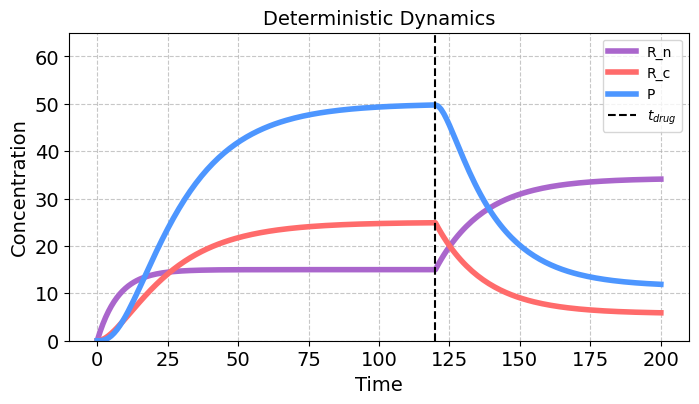

In [16]:
# Running the ODE model
time, concentrations_species = simulate_model(parameter_values,
                                                      initial_conditions,
                                                      total_simulation_time,
                                                      simulation_type='continuous', 
                                                      burn_in_time=burn_in_time,
                                                      drug_application_time=drug_application_time,
                                                      inhibited_parameters=inhibited_parameters)
plotting_deterministic(time,concentrations_species,species_colors,drug_application_time,ylim_val=max_y_val,save_figure=True,plot_name='det_inhibition.jpg',folder_outputs=folder_outputs)

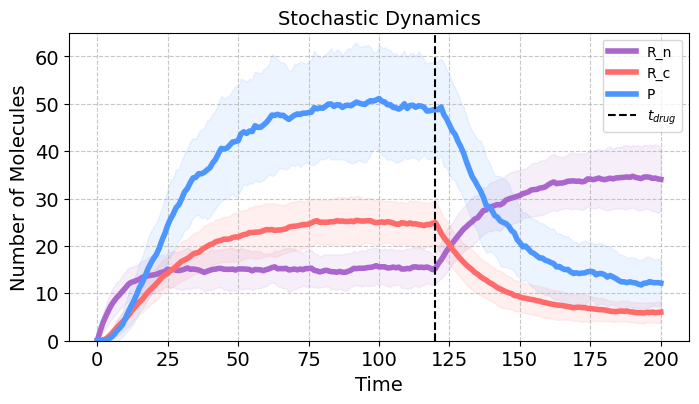

In [17]:
# Running SSA
time, trajectories_species = simulate_model(parameter_values,
                                                  initial_conditions,
                                                  total_simulation_time,
                                                  simulation_type='discrete', 
                                                  burn_in_time=burn_in_time,
                                                  drug_application_time=drug_application_time,
                                                  inhibited_parameters=inhibited_parameters,
                                                  number_of_trajectories=number_of_trajectories)
plotting_stochastic(time, trajectories_species,species_colors,drug_application_time,ylim_val=max_y_val,save_figure=True,plot_name='ssa_inhibition.jpg',folder_outputs=folder_outputs)

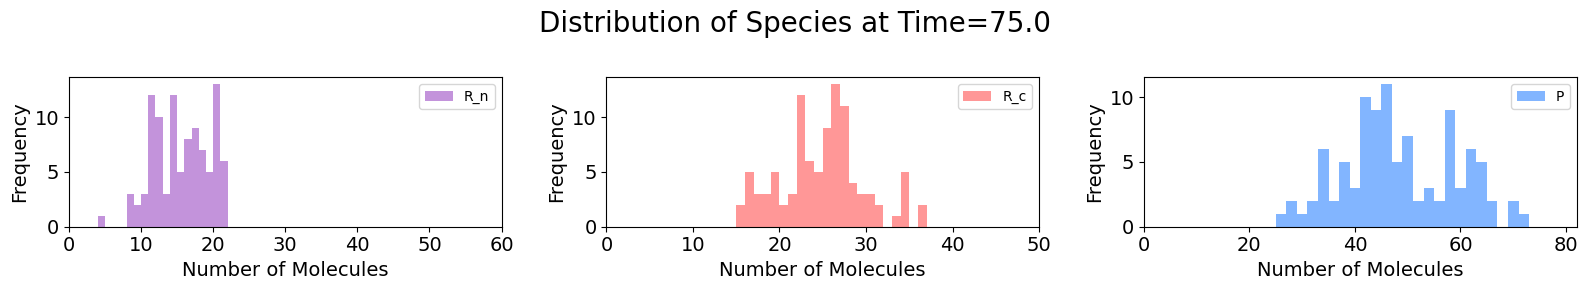

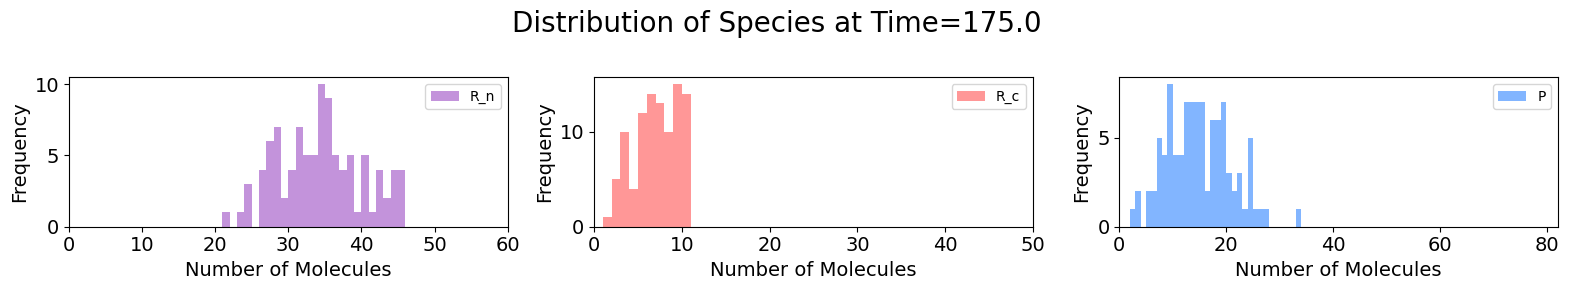

In [ ]:
xlim_vals = { 'R_n': (0,60), 'R_c':(0,50), 'P': (0, 82)}  # Example x-axis limits for each species
plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point=75, xlim_vals=xlim_vals,folder_outputs=folder_outputs)
plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point=175, xlim_vals=xlim_vals,folder_outputs=folder_outputs)
